## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
# Visualizations will be shown in the notebook.
%matplotlib inline
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname) 
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imwrite('output_images/drawChessboardCorners/' + fname.split('/')[-1], img)

# Camera Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Distortion correction

In [2]:
def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

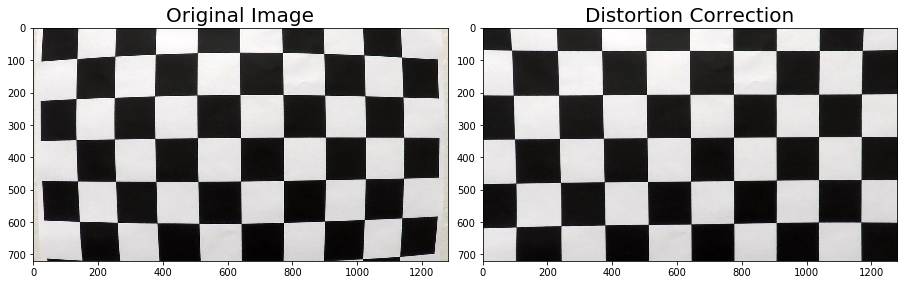

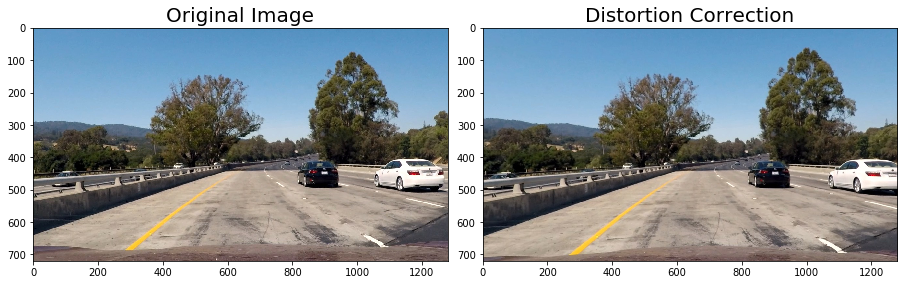

In [3]:
# Test Undistorting image
image = mpimg.imread('camera_cal/calibration1.jpg') 
undistort_image = cal_undistort(image)

# Plot in notebook
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistort_image)
ax2.set_title('Distortion Correction', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)
# Save to local disk
plt.savefig('output_images/distortion_correction_sample.png')

image = mpimg.imread('test_images/test1.jpg')
undistort_image = cal_undistort(image)

# Plot in notebook
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistort_image)
ax2.set_title('Distortion Correction', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)
# Save to local disk
plt.savefig('output_images/distortion_correction.png')

## Color and Gradient threshold

### Combining Thresholds

In [4]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):

    sobel = None
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return grad_binary

def mag_threshold(image, sobel_kernel=3, thresh=(0, 255)):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return dir_binary

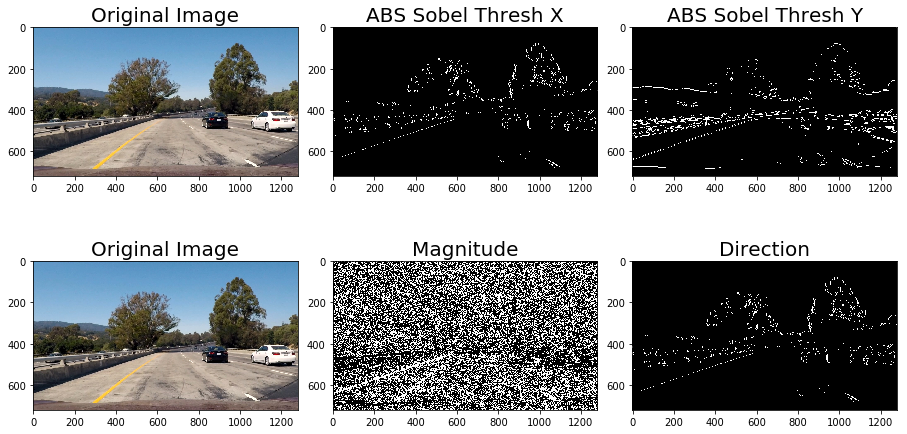

In [5]:
# Test Combining Thresholds
image = mpimg.imread('test_images/test1.jpg') 
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 100))
mag_binary = mag_threshold(image, sobel_kernel=ksize, thresh=(50, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Plot in notebook
f, (ax) = plt.subplots(2, 3, figsize=(15, 6))
f.tight_layout()

ax[0][0].imshow(image)
ax[0][0].set_title('Original Image', fontsize=20)
ax[0][1].imshow(gradx, cmap='gray')
ax[0][1].set_title('ABS Sobel Thresh X', fontsize=20)
ax[0][2].imshow(grady, cmap='gray')
ax[0][2].set_title('ABS Sobel Thresh Y', fontsize=20)
ax[1][0].imshow(image)
ax[1][0].set_title('Original Image', fontsize=20)
ax[1][1].imshow(dir_binary, cmap='gray')
ax[1][1].set_title('Magnitude', fontsize=20)
ax[1][2].imshow(gradx, cmap='gray')
ax[1][2].set_title('Direction', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.)

# Save to local disk
plt.savefig('output_images/combining_thresholds.png')

### HLS space

In [6]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l = hls[:,:,1]
    s = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    l_sum_light = sum(map(sum, l[int(l.shape[0]/2):,:]))
    s_sum_light = sum(map(sum, s[int(s.shape[0]/2):,:]))
    binary_output = np.zeros_like(s)
    if (l_sum_light >= s_sum_light):
        binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    else:
        binary_output[(l >= thresh[0]) & (l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

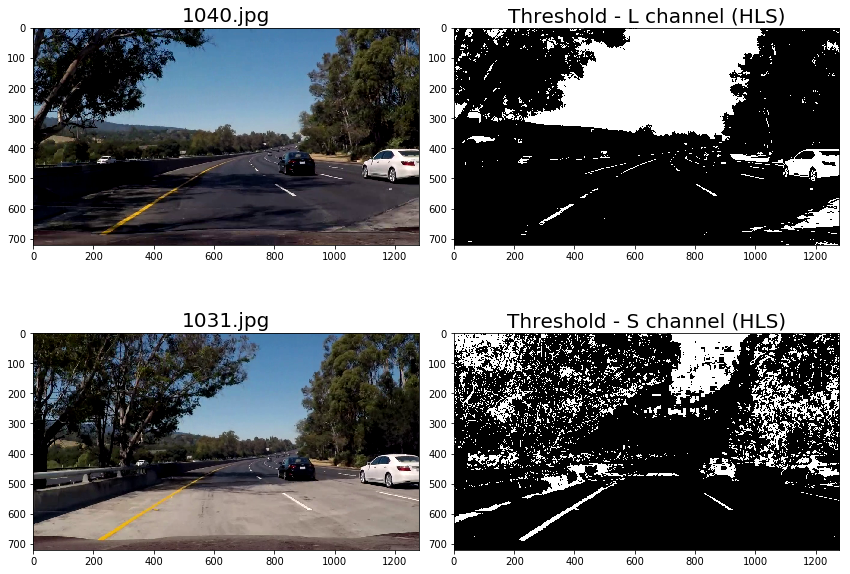

In [7]:
# Test HLS select
image = mpimg.imread('test_images/new/1040.jpg')
hls_image = hls_select(image, thresh=(100, 255))
image2 = mpimg.imread('test_images/new/1031.jpg')
hls_image2 = hls_select(image2, thresh=(100, 255))

# Plot in notebook
f, (ax) = plt.subplots(2, 2, figsize=(14, 8))
f.tight_layout()
ax[0][0].imshow(image)
ax[0][0].set_title('1040.jpg', fontsize=20)
ax[0][1].imshow(hls_image, cmap='gray')
ax[0][1].set_title('Threshold - L channel (HLS)', fontsize=20)
ax[1][0].imshow(image2)
ax[1][0].set_title('1031.jpg', fontsize=20)
ax[1][1].imshow(hls_image2, cmap='gray')
ax[1][1].set_title('Threshold - S channel (HLS)', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.)

# Save to local disk
plt.savefig('output_images/thresholds_hls_channel.png')

### Pipeline Threshold

In [8]:
def pipeline_threshold(img, kernel_size=15, gradxy_thresh=(50, 100), mag_thresh=(50, 100), dir_thresh=(0.7, 1.3), s_thresh=(100, 255)):
    img = np.copy(img)

    # Threshold x gradient
    gradx = abs_sobel_thresh(img, 'x', sobel_kernel=kernel_size, thresh=gradxy_thresh)

    # Threshold y gradient
    grady = abs_sobel_thresh(img, 'y', sobel_kernel=kernel_size, thresh=gradxy_thresh)

    # Magnitude
    mag_binary = mag_threshold(img, sobel_kernel=kernel_size, thresh=mag_thresh)

    # Direction
    dir_binary = dir_threshold(image, sobel_kernel=kernel_size, thresh=dir_thresh)

    # Threshold gray combine
    gray_combined = np.zeros_like(dir_binary)

    #gray_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    gray_combined[(gradx == 1) & (mag_binary == 1) & (dir_binary == 1)] = 1

    # Threshold color channel
    ls_binary = hls_select(img, thresh=s_thresh)

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(ls_binary), ls_binary, gray_combined))

    # Threshold combine
    combined = np.zeros_like(dir_binary)
    combined[((ls_binary == 1) | (gray_combined == 1))] = 1

    return color_binary, combined

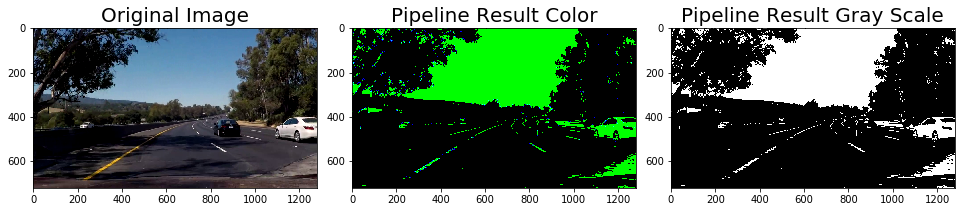

In [9]:
# Test Pipeline Threshold
image = mpimg.imread('test_images/new/1040.jpg')
color_result, gray_result = pipeline_threshold(image)

# Plot in notebook
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(color_result)
ax2.set_title('Pipeline Result Color', fontsize=20)

ax3.imshow(gray_result, cmap='gray')
ax3.set_title('Pipeline Result Gray Scale', fontsize=20)

plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.)

# Save to local disk
plt.savefig('output_images/pipeline_threshold.png')

## Perspective transform

In [10]:
def get_points(img):
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
        [[(img_size[0] / 2 - 85), img_size[1] / 2 + 100],
        [                      0, img_size[1]],
        [            img_size[0], img_size[1]],
        [ (img_size[0] / 2 + 85), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    return src, dst

def warped_process(img):
    img_size = (img.shape[1], img.shape[0])

    # 1) Undistort
    img = cal_undistort(img)
    # 2) Get source points and dest. points
    src, dst = get_points(img)
    # 3) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # 4) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

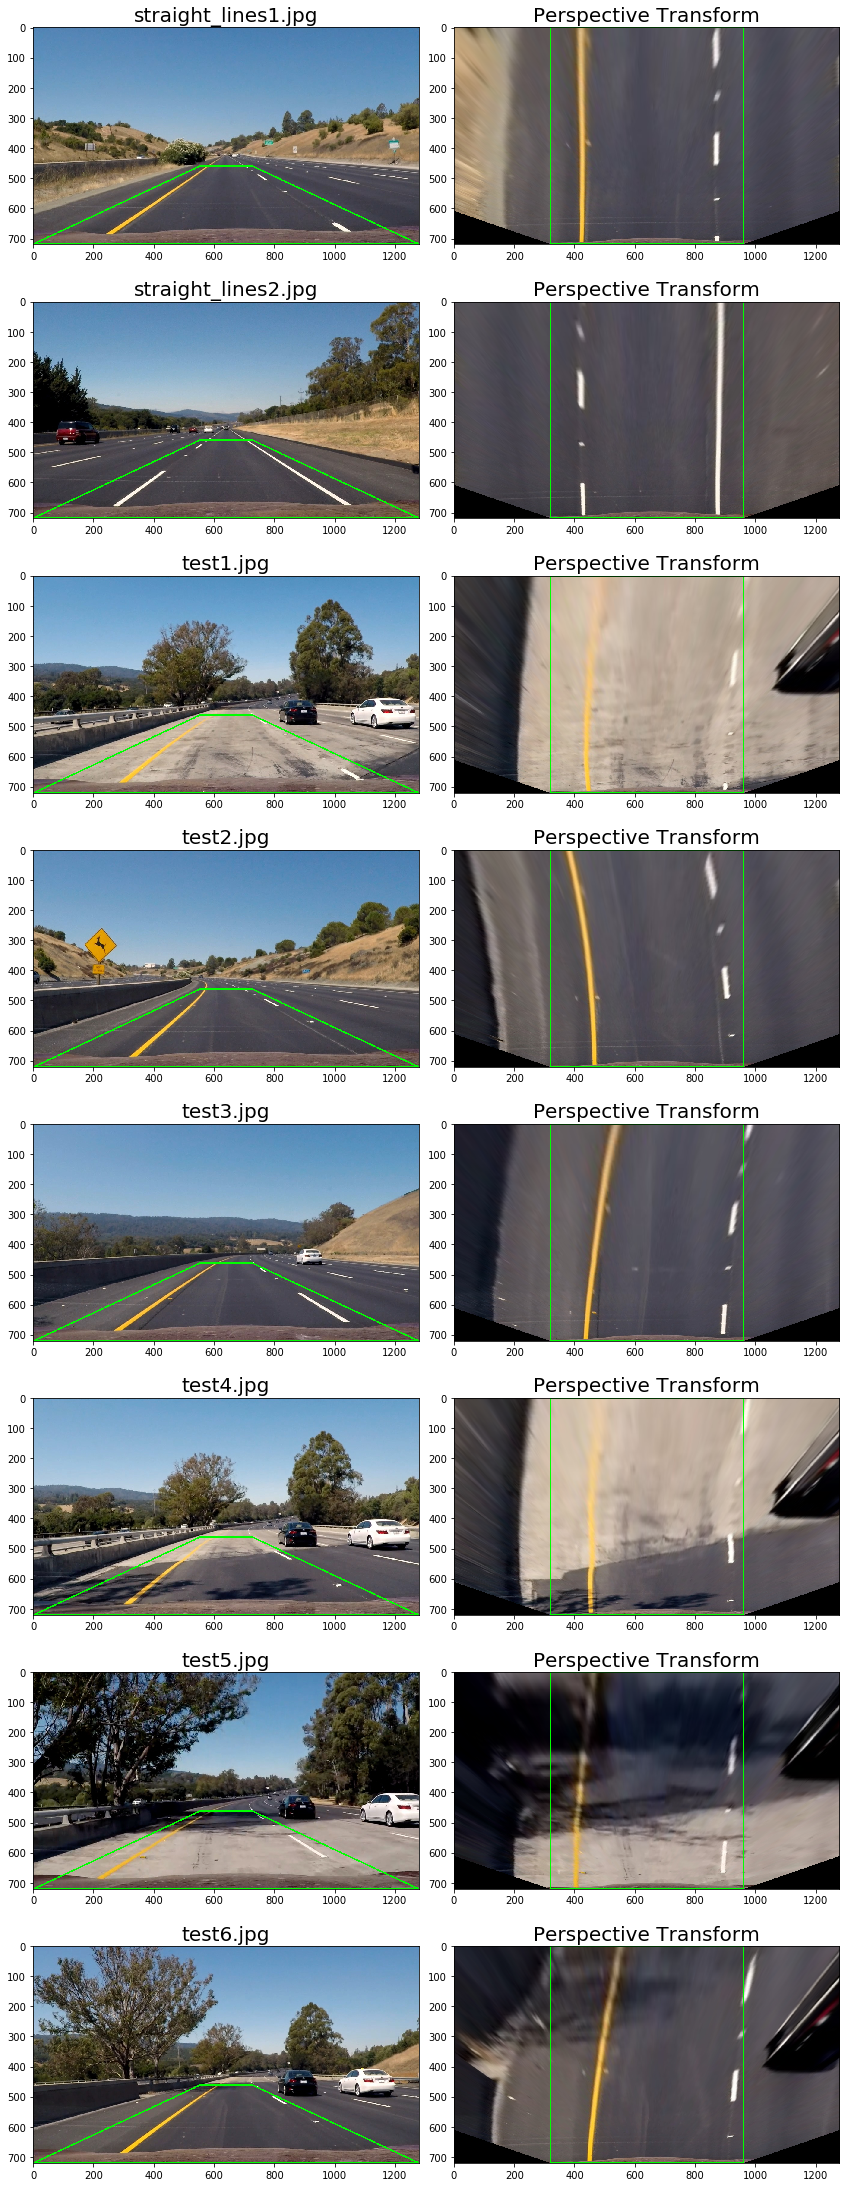

In [11]:
# Test Perspective Transform
images = glob.glob('test_images/*.jpg')
input_images = []
output_images = []
for image_name in images:
    image = mpimg.imread(image_name)
    top_down, M, Minv = warped_process(image)

    # Draw source points and dest. points in to images
    src, dst = get_points(image)

    pts_src = np.array(src, np.int32)
    cv2.polylines(image, [pts_src], True, (0,255,0), 4)

    pts_dst = np.array(dst, np.int32)
    cv2.polylines(top_down, [pts_dst], True, (0,255,0), 4)

    input_images.append(image)
    output_images.append(top_down)

# Plot in notebook
num_of_output = len(output_images)
f, (ax) = plt.subplots(num_of_output, 2, figsize=(14, 30))
f.tight_layout()
for i in range(num_of_output):
    ax[i][0].imshow(input_images[i])
    ax[i][0].set_title('%s' %images[i].split('\\')[-1].split('/')[-1], fontsize=20)
    ax[i][1].imshow(output_images[i])
    ax[i][1].set_title('Perspective Transform', fontsize=20)
    
    plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.)

# Save to local disk
plt.savefig('output_images/perspective_transform.png')

## Sliding Window Search

In [12]:
# Draw window areas
def window_mask(width, height, img_ref, centerx, centery):
    img_ref_height = img_ref.shape[0]
    img_ref_width = img_ref.shape[1]
    output = np.zeros_like(img_ref)
    output[max(0, int(centery-height/2)) : min(int(centery+height/2), img_ref_height),
           max(0, int(centerx-width/2)) : min(int(centerx+width/2), img_ref_width)] = 1
    return output

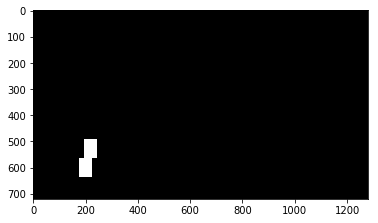

In [13]:
# Test window mask
image = np.zeros((720,1280,3), np.uint8)
l_points = np.zeros_like(image)

mask = window_mask(50, 72, image, 200.0, 600.0)
l_points[(l_points == 255) | ((mask == 1) ) ] = 255
mask = window_mask(50, 72, image, 220.0, 528.0)
l_points[(l_points == 255) | ((mask == 1) ) ] = 255

plt.figure()
plt.imshow(l_points)

In [14]:
# Find all window centroids
def find_window_centroids(image, window_centroids_pre=[], window_width=60, window_height=18, margin=20):

    img_width = image.shape[1]
    img_height = image.shape[0]

    # Store the (left,right) window centroid positions per level
    window_centroids = []
    # Create our window template that we will use for convolutions
    window = np.ones(window_width)

    # First find the two starting positions for the left and right lane by using np.sum
    # to get the vertical image slice and then np.convolve the vertical image slice 
    # with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    # Use window_width/2 as offset because convolution signal reference is 
    # at right side of window, not center of window
    offset = window_width/2 # Adjust position of mask window
    offset_window = int(img_width/5) # Decrease region for line detection
    offset_frame = window_width
    len_of_lane = 470 # Default value

    l_sum = np.sum(image[int(3*img_height/4):, offset_window:int(img_width/2)], axis=0)
    l_conv = np.convolve(window, l_sum)
    l_max = np.argmax(l_conv) + offset_window

    r_sum = np.sum(image[int(3*img_height/4):, int(img_width/2):int(img_width)-offset_window], axis=0)
    r_conv = np.convolve(window, r_sum)
    r_max = np.argmax(r_conv)

    l_center = 0
    r_center = int(img_width/2) # Change from Relative Position to Absolute Position

    if (l_max > 0 and r_max == 0): # Cannot find r_center
        l_center = l_max - offset
        r_center = l_center + len_of_lane + 20
    elif (l_max == 0 and r_max > 0): # Cannot find l_center
        r_center += r_max - offset + 20
        l_center = r_center - len_of_lane
    elif (l_max > 0 and r_max > 0): # Found l_center and r_center
        l_center = l_max - offset
        r_center += r_max - offset + 20
        if (abs(r_center - l_center - len_of_lane) > offset_frame):
            if (np.average(l_conv) >= np.average(r_conv)): # Find trustly point
                r_center = l_center + len_of_lane
            else:
                l_center = r_center - len_of_lane

    # Add what we found for the first 
    if len(window_centroids_pre) > 0:
        l_center_pre = window_centroids_pre[0][0]
        r_center_pre = window_centroids_pre[0][1]

        if abs(l_center_pre-l_center) > offset_frame:
            l_center = l_center_pre
        if abs(r_center_pre-r_center) > offset_frame:
            r_center = r_center_pre

    window_centroids.append((l_center, r_center, img_height))
    len_of_lane = r_center - l_center # Update len_of_lane

    # Go through each layer looking for max pixel locations
    num_of_layer = int(img_height/window_height)
    for level in range(1, num_of_layer):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(img_height-(level+1)*window_height):
                                    int(img_height-level*window_height),
                                    :], axis=0)
        conv_signal = np.convolve(window, image_layer)

        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center + offset - margin, 0))
        l_max_index = int(min(l_center + offset + margin, img_width))
        l_max = 0
        l_conv_signal = conv_signal[l_min_index:l_max_index]
        if (len(l_conv_signal) > 0):
            l_max = np.argmax(l_conv_signal)

        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center + offset - margin, 0))
        r_max_index = int(min(r_center + offset + margin, img_width))
        r_max = 0
        r_conv_signal = conv_signal[r_min_index:r_max_index]
        if (len(r_conv_signal) > 0):
            r_max = np.argmax(l_conv_signal)

        if (l_max > 0 and r_max == 0):
            l_center = l_max + l_min_index - offset
        elif (l_max == 0 and r_max > 0):
            r_center = r_max + r_min_index - offset
        elif (l_max > 0 and r_max > 0):
            l_center = l_max + l_min_index - offset
            r_center = r_max + r_min_index - offset
        # Cannot find l_center and r_center: keep previous value

        # Add what we found for that layer
        if len(window_centroids_pre) > 0:
            l_center_pre = window_centroids_pre[level][0]
            r_center_pre = window_centroids_pre[level][1]
            if abs(l_center_pre-l_center) > offset_frame:
                l_center = l_center_pre
            if abs(r_center_pre-r_center) > offset_frame:
                r_center = r_center_pre

        window_centroids.append((l_center, r_center, img_height-level*window_height))
        len_of_lane = r_center - l_center # Update len_of_lane
    window_centroids = np.array(window_centroids)
    window_centroids[-1][2] = 0 # Fix image to map with frame

    return window_centroids

In [15]:
def cal_line_fit(window_centroids):
    lines_fit = np.asarray(window_centroids).T
    leftx = lines_fit[0]
    rightx = lines_fit[1]
    ploty = lines_fit[2]
    left_fit = np.polyfit(ploty, leftx, 2) # f(y)=Ay**2 + By + C
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2) # f(y)=Ay**2 + By + C
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return leftx, left_fit, left_fitx, rightx, right_fit, right_fitx, ploty

# Draw all window centroids
def draw_window_results(image, window_centroids, window_width=50, window_height=72):

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows
        for level in range(0, len(window_centroids)):
            l_mask = window_mask(window_width,
                                    window_height,
                                    image,
                                    window_centroids[level][0],
                                    window_centroids[level][2])
            r_mask = window_mask(window_width,
                                    window_height,
                                    image,
                                    window_centroids[level][1],
                                    window_centroids[level][2])
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        #template = np.array(r_points + l_points, np.uint8)
        r_template = np.array(r_points, np.uint8)
        l_template = np.array(l_points, np.uint8)

        # create a zero color channel
        zero_channel = np.zeros_like(r_template)
        # make window pixels green
        r_template = np.array(cv2.merge((zero_channel, zero_channel, r_template)),np.uint8)
        l_template = np.array(cv2.merge((l_template, zero_channel, zero_channel)),np.uint8)

        # making the original road pixels 3 color channels
        warpage = np.array(cv2.merge((image, image, image)),np.uint8)

        # overlay the orignal road image with window results
        template = cv2.addWeighted(r_template, 1, l_template, 1, 0.0)
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

        # Draw line fit
        cal_line = cal_line_fit(window_centroids)
        left_fitx = cal_line[2]
        right_fitx = cal_line[5]
        ploty = cal_line[6]
        
        pts_src = np.array([left_fitx, ploty],  np.int32).T
        cv2.polylines(output, [pts_src], False, (0,255,0), thickness=10)#, lineType=cv2.CV_AA)
        pts_src = np.array([right_fitx, ploty],  np.int32).T
        cv2.polylines(output, [pts_src], False, (0,255,0), thickness=10)#, lineType=cv2.CV_AA)

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((image, image, image)),np.uint8)

    return output

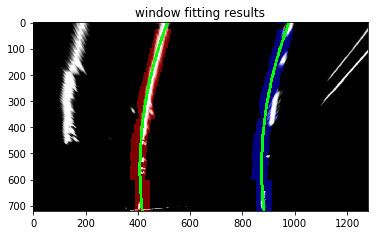

In [16]:
# Test Sliding Window Search
window_centroids_pre = [] # init

image = mpimg.imread('test_images/new/1045.jpg')
color_image, thresh_image = pipeline_threshold(image, kernel_size=15, 
                                               gradxy_thresh=(50, 100), 
                                               mag_thresh=(50, 100), 
                                               dir_thresh=(0.7, 1.3), 
                                               s_thresh=(100, 255))
warped_image, M, Minv = warped_process(thresh_image)
warped_image = np.uint8(255*warped_image) # un-scaled
warped_image = cv2.GaussianBlur(warped_image,(5,5), 0)

window_width = 60
window_height = int(image.shape[0]/40)
margin = 20 # How much to slide left and right for searching
window_centroids = find_window_centroids(warped_image, window_centroids_pre, window_width, window_height, margin)
window_centroids_pre = window_centroids # backup
output = draw_window_results(warped_image, window_centroids, window_width, window_height)

# Display the final results
plt.figure()
plt.imshow(output)
plt.title('window fitting results')

# Save to local disk
plt.savefig('output_images/window_fitting.png')

## Measuring Curvature

In [17]:
def measuring_curvature(linex, ploty, y_eval, xm_per_pix=3.7/500, ym_per_pix=20/720):
    # Fit new polynomials to x,y in world space
    line_fit_cr = np.polyfit(ploty*ym_per_pix, linex*xm_per_pix, 2) # f(y)=Ay**2 + By + C

    line_curverad = ((1 + (2*line_fit_cr[0]*y_eval*ym_per_pix + line_fit_cr[1])**2)**1.5) / np.absolute(2*line_fit_cr[0])
    return line_curverad

### Test Measuring Curvature

In [18]:
image = mpimg.imread('test_images/new/1045.jpg')
color_image, thresh_image = pipeline_threshold(image)
warped_image, M, Minv = warped_process(thresh_image)
warped_image = np.uint8(255*warped_image) # un-scaled
warped_image = cv2.GaussianBlur(warped_image,(5,5), 0)

window_width = 60
window_height = int(image.shape[0]/40)
margin = 20 # How much to slide left and right for searching
window_centroids = find_window_centroids(warped_image, [], window_width, window_height, margin)

cal_line = cal_line_fit(window_centroids)
leftx = cal_line[0]
left_fitx = cal_line[2]
rightx = cal_line[3]
right_fitx = cal_line[5]
ploty = cal_line[6]        

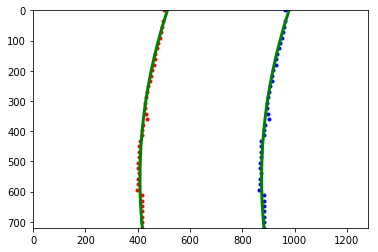

In [19]:
# Plot up the data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.xlim(0, 1280)
plt.ylim(0, 720)

plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [20]:
# Test Measuring Curvature
y_eval = np.max(ploty)
xm_per_pix=3.7/500
ym_per_pix=20/720

# Calculate the new radius of curvature
left_curverad = measuring_curvature(leftx, ploty, y_eval, xm_per_pix, ym_per_pix)
right_curverad = measuring_curvature(rightx, ploty, y_eval, xm_per_pix, ym_per_pix)

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

154.323229725 m 154.323229725 m


## Drawing Lane

In [21]:
def drawing_lane(image, warped, Minv, left_fitx, right_fitx, ploty):
    img_size = (image.shape[1], image.shape[0])

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(cal_undistort(image), 1, newwarp, 0.3, 0)

    return result

## Process Image

In [22]:
window_centroids_pre = [] # init
debug_mode = True
def process_image(image):
    global window_centroids_pre

    # Step 1
    color_image, thresh_image = pipeline_threshold(image, kernel_size=15, 
                                               gradxy_thresh=(50, 100), 
                                               mag_thresh=(50, 100), 
                                               dir_thresh=(0.7, 1.3), 
                                               s_thresh=(100, 255))
    # Step 2
    warped_image, M, Minv = warped_process(thresh_image)
    warped_image = np.uint8(255*warped_image) # un-scaled
    blur_image = cv2.GaussianBlur(warped_image,(5,5), 0)

    # Step 3
    window_width = 60
    window_height = int(image.shape[0]/40) # Break image into 9 vertical layers since image height is 720
    margin = 20 # How much to slide left and right for searching
    window_centroids = find_window_centroids(blur_image, window_centroids_pre, window_width, window_height, margin)
    window_centroids_pre = window_centroids # backup
    draw_window = draw_window_results(blur_image, window_centroids, window_width, window_height)

    # Step 4
    cal_line = cal_line_fit(window_centroids)
    leftx = cal_line[0]
    left_fit = cal_line[1]
    left_fitx = cal_line[2]
    rightx = cal_line[3]
    right_fit = cal_line[4]
    right_fitx = cal_line[5]
    ploty = cal_line[6]

    y_eval = np.max(ploty)
    xm_per_pix=3.7/500
    ym_per_pix=20/720
    left_curverad = measuring_curvature(leftx, ploty, y_eval, xm_per_pix, ym_per_pix)
    right_curverad = measuring_curvature(rightx, ploty, y_eval, xm_per_pix, ym_per_pix)
    lane_curverad = (left_curverad + right_curverad)/2

    # Step 5
    result = drawing_lane(image, blur_image, Minv, left_fitx, right_fitx, ploty)

    # Add text
    deviation = ((right_fitx[0] + left_fitx[0]) / 2 - image.shape[1] / 2) * xm_per_pix
    staus_text1 = 'Radius of Curvature is %d(m)' %int(lane_curverad)
    staus_text2 = 'Vehicle is in center'
    if deviation > 0:
        staus_text2 = 'Vehicle is %.2f left of center' %abs(deviation)
    elif deviation < 0:
        staus_text2 = 'Vehicle is %.2f right of center' %abs(deviation)

    cv2.putText(result, staus_text1, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 3)
    cv2.putText(result, staus_text2, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 3)

    if debug_mode:
        return thresh_image, warped_image, draw_window, result
    else:
        return result

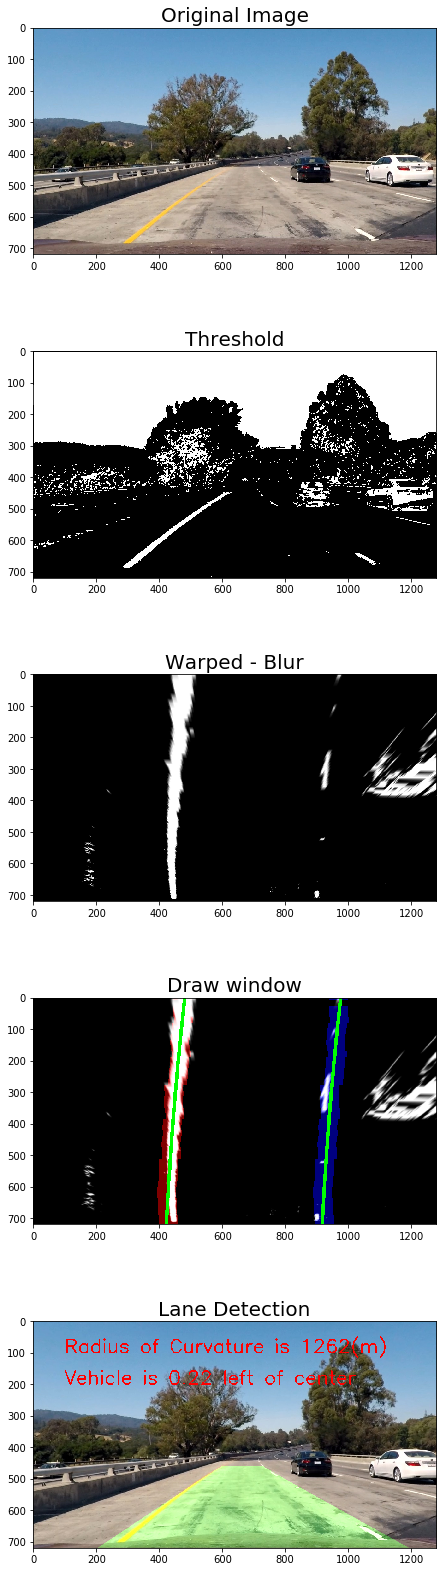

In [23]:
debug_mode = True
image = mpimg.imread('test_images/test1.jpg')
window_centroids_pre = [] # init
output_image = process_image(image)

# Plot in notebook
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(7, 22))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(output_image[0], cmap='gray')
ax2.set_title('Threshold', fontsize=20)
ax3.imshow(output_image[1], cmap='gray')
ax3.set_title('Warped - Blur', fontsize=20)
ax4.imshow(output_image[2])
ax4.set_title('Draw window', fontsize=20)
ax5.imshow(output_image[3])
ax5.set_title('Lane Detection', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.)

# Save to local disk
plt.savefig('output_images/lane_detection.png')

In [24]:
# Make a list of calibration images
images = glob.glob('test_images/new/*.jpg')

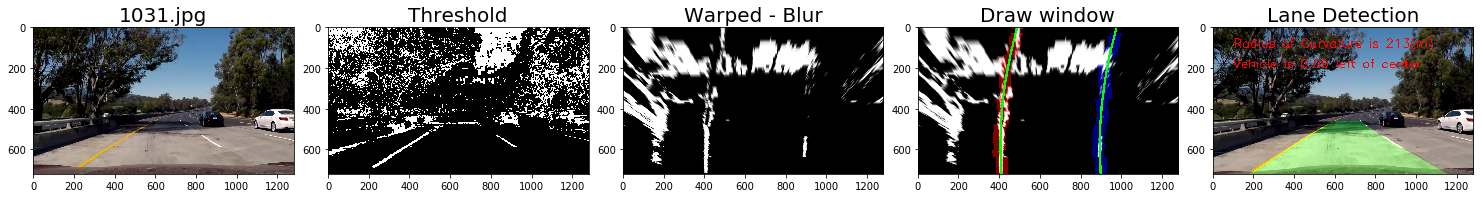

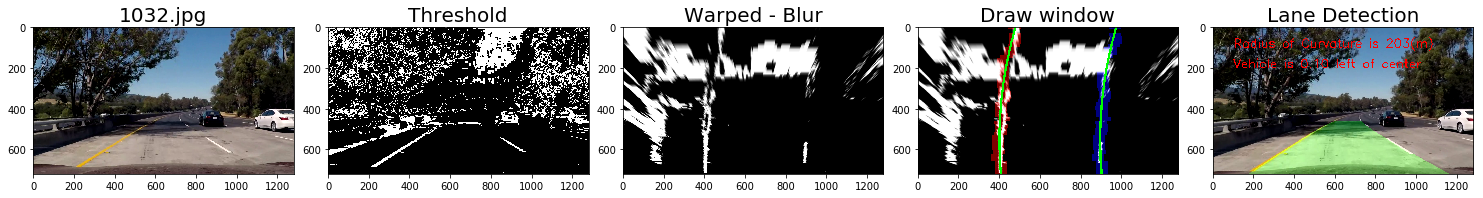

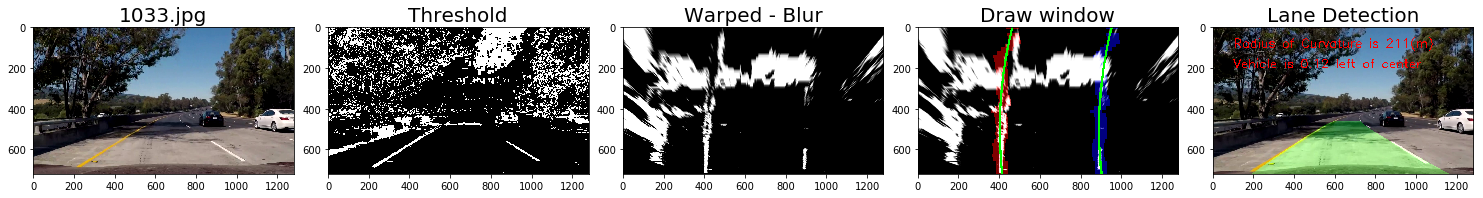

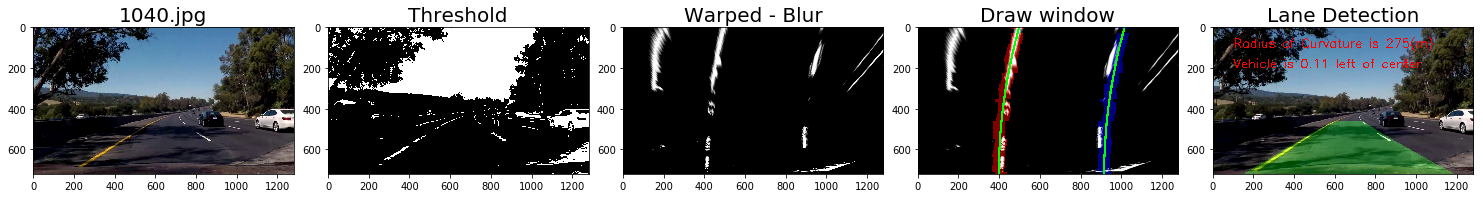

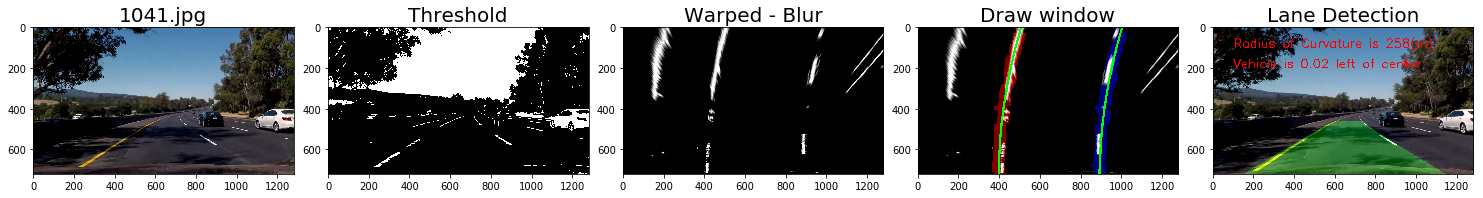

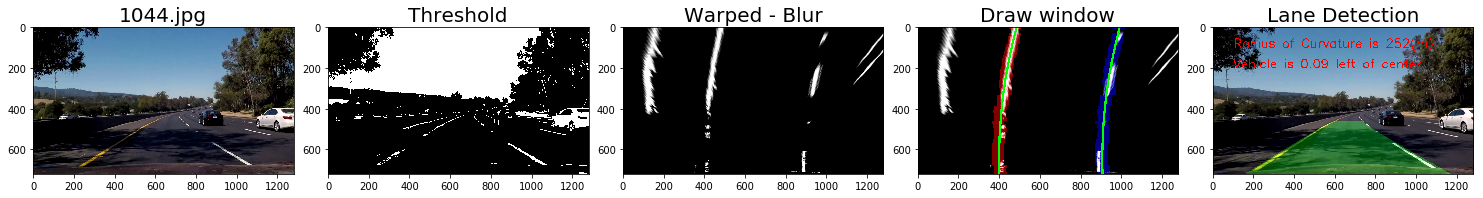

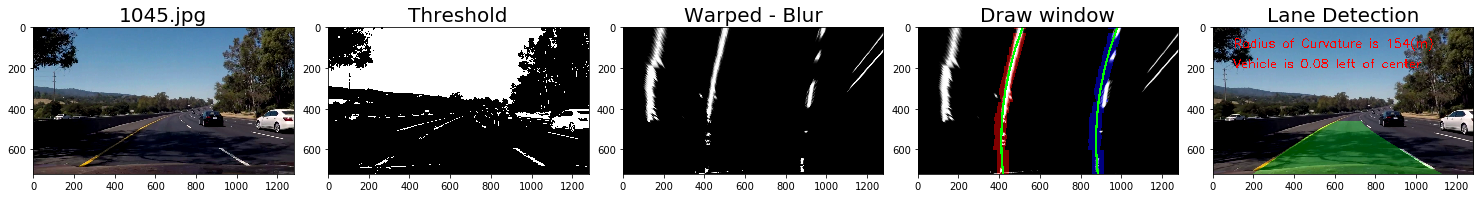

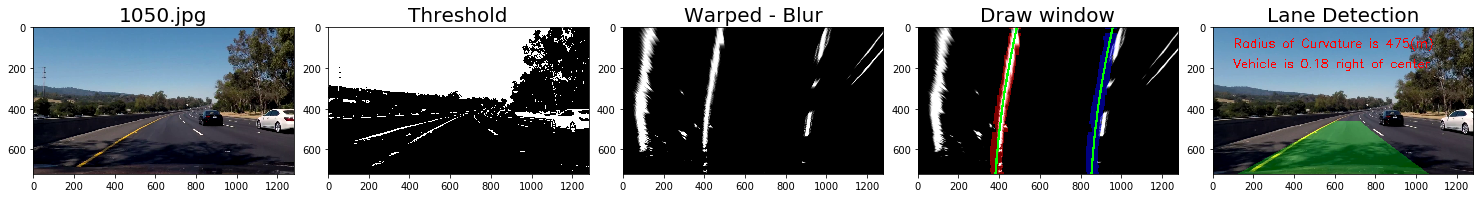

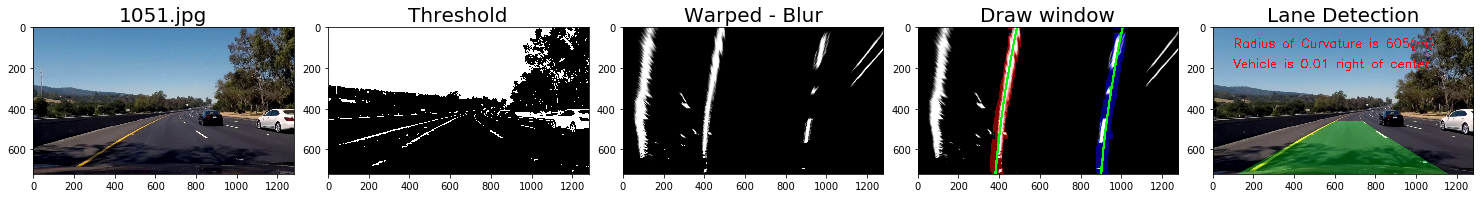

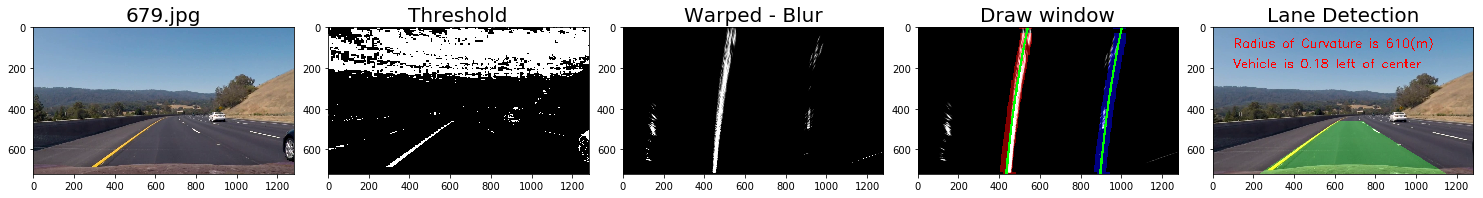

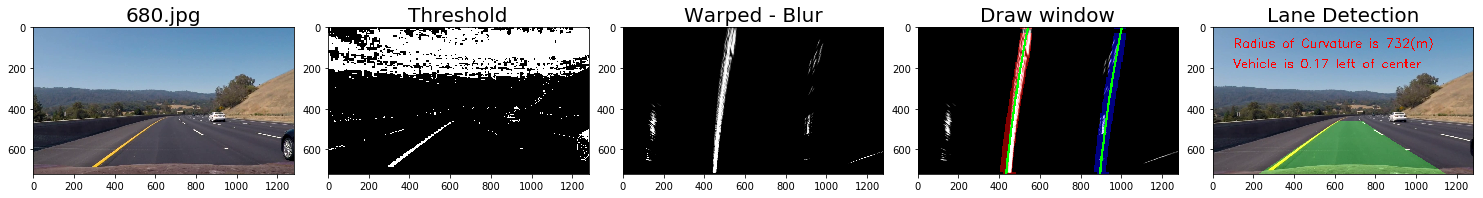

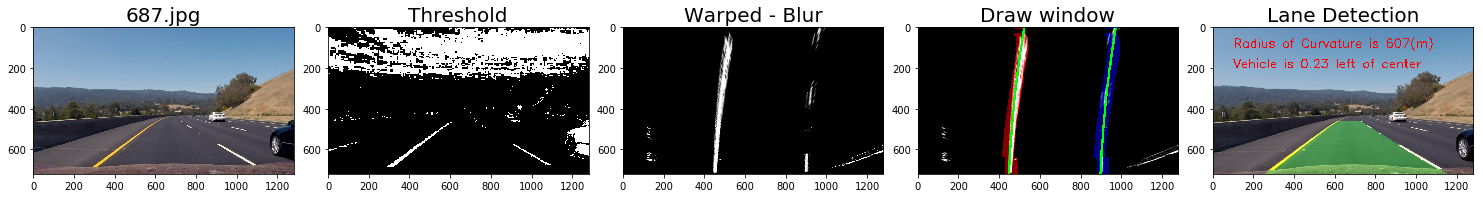

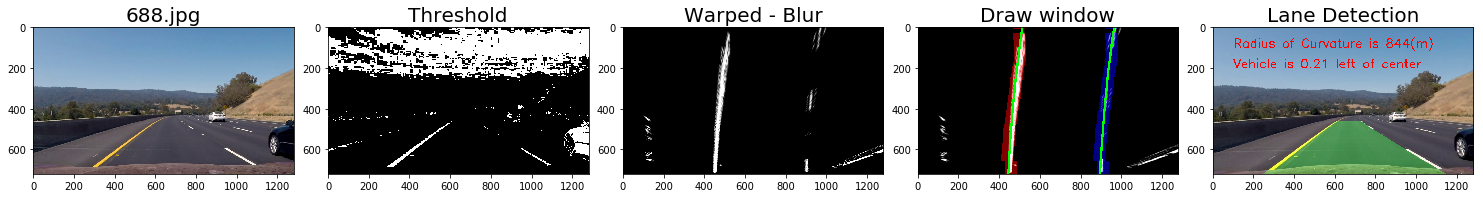

In [25]:
#Test
debug_mode = True
input_images = []
output_images = []
for image_name in images:
    image = mpimg.imread(image_name)
    input_images.append(image)
    window_centroids_pre = [] # init
    output_images.append(process_image(image))

# Plot in notebook
num_of_output = len(output_images)
for i in range(num_of_output):
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))
    f.tight_layout()

    ax1.imshow(input_images[i])
    ax1.set_title('%s' %images[i].split('\\')[-1].split('/')[-1], fontsize=20)
    ax2.imshow(output_images[i][0], cmap='gray')
    ax2.set_title('Threshold', fontsize=20)
    ax3.imshow(output_images[i][1], cmap='gray')
    ax3.set_title('Warped - Blur', fontsize=20)
    ax4.imshow(output_images[i][2])
    ax4.set_title('Draw window', fontsize=20)
    ax5.imshow(output_images[i][3])
    ax5.set_title('Lane Detection', fontsize=20)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.)

## Test on Videos

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_path = 'output_videos/'

In [ ]:
# For Testing and Debugging
debug_mode = True
video_name = 'project_video.mp4'
cap = cv2.VideoCapture(video_name)
i = 0
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == False:
        continue

    # Our operations on the frame come here
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    out = process_image(rgb)

    warped_bgr = cv2.cvtColor(out[2], cv2.COLOR_RGB2BGR)
    bgr = cv2.cvtColor(out[3], cv2.COLOR_RGB2BGR)

    # Display the resulting frame
    '''
    cv2.imwrite(output_path + 'input_images/%d.jpg' %i, frame)
    cv2.imwrite(output_path + 'output_images/%d.jpg' %i, bgr)
    i += 1
    '''
    cv2.namedWindow('Warped', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Warped', 400, 300)
    cv2.imshow('Warped', warped_bgr)
    cv2.imwrite(output_path + 'output_images/Warped.png', warped_bgr)
    cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video', 400, 300)
    cv2.imshow('Video', bgr)
    k = cv2.waitKey(33)
    if k==27:    # Esc key to stop
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

### Video Project

In [27]:
window_centroids_pre = [] # init
debug_mode = False

video_name = 'project_video.mp4'
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+video_name, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [22:35<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 26min 2s, sys: 4.17 s, total: 26min 6s
Wall time: 22min 38s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_name))

### Video Challenge

In [ ]:
'''
video_name = 'challenge_video.mp4'
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+video_name, audio=False)
'''

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_name))

### Video Harder Challenge

In [ ]:
'''
video_name = 'harder_challenge_video.mp4'
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_path+video_name, audio=False)
'''

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path+video_name))